In [1]:
import torch
from dataset.get_datasets import get_dataset
import warnings
import numpy as np
from dataset.scaffold import ogbg_with_smiles
import os 
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('./plotter/')
from plotter.plot import convert_idx_list, Orig_Plotter
from dataset.scaffold import get_scaffold_split_info, _generate_scaffold, generate_scaffolds_dict

warnings.filterwarnings('ignore')

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)    

class Args:
    def __init__(self):
        self.dataset = 'ogbg-molbace'
        self.device = device
        self.batch_size = 128
        
args = Args()


labeled_dataset = get_dataset(args, './raw_data')
labeled_dataset_list = [data for data in labeled_dataset]
smile_path = os.path.join('./raw_data', '_'.join(args.dataset.split('-')), 'mapping/mol.csv.gz')
smiles_df = pd.read_csv(smile_path, compression='gzip', usecols=['smiles'])
smiles = smiles_df['smiles'].tolist() 

new_labeled_dataset = ogbg_with_smiles(name = args.dataset,
                                   root = './raw_data',
                                   data_list = labeled_dataset_list, 
                                   smile_list = smiles)
label_split_idx_scaffold = new_labeled_dataset.get_idx_split(split_type = 'scaffold')

cuda
None


In [15]:
len(new_labeled_dataset.scaff_smiles)

1513

In [16]:
# scaffold set with index; ordered by the scaffold frequency
_, all_scaffolds_set = generate_scaffolds_dict(smiles)
print(f'There are {len(all_scaffolds_set)} scaffolds in total and {len(new_labeled_dataset)} molecules in the dataset.')
# get scaffold smiles
all_scaffolds_smiles = [tup[0] for tup in all_scaffolds_set]

train_smiles = [smiles[i] for i in label_split_idx_scaffold['train']]
_, train_scaffold = generate_scaffolds_dict(train_smiles)
train_scaffold_num = dict([(tup[0], len(tup[1])) for tup in train_scaffold])

valid_smiles = [smiles[i] for i in label_split_idx_scaffold['valid']]
_, valid_scaffold = generate_scaffolds_dict(valid_smiles)
valid_scaffold_num = dict([(tup[0], len(tup[1])) for tup in valid_scaffold])

test_smiles = [smiles[i] for i in label_split_idx_scaffold['test']]
_, test_scaffold = generate_scaffolds_dict(test_smiles)
test_scaffold_num = dict([(tup[0], len(tup[1])) for tup in test_scaffold])

There are 675 scaffolds in total and 1513 molecules in the dataset.


In [17]:
for scaffold_smile in all_scaffolds_smiles:
    if scaffold_smile not in train_scaffold_num:
        train_scaffold_num[scaffold_smile] = 0
    if scaffold_smile not in valid_scaffold_num:
        valid_scaffold_num[scaffold_smile] = 0
    if scaffold_smile not in test_scaffold_num:
        test_scaffold_num[scaffold_smile] = 0
        
train_scaffold_num = dict(sorted(train_scaffold_num.items(), key=lambda item: item[0]))
valid_scaffold_num = dict(sorted(valid_scaffold_num.items(), key=lambda item: item[0]))
test_scaffold_num = dict(sorted(test_scaffold_num.items(), key=lambda item: item[0]))

In [18]:
scaffold_split_dict = {}
scaffold_num_dict = {}
for scaffold_smile in all_scaffolds_smiles:
    if train_scaffold_num[scaffold_smile] > 0:
        scaffold_split_dict[scaffold_smile] = 'train'
        scaffold_num_dict[scaffold_smile] = train_scaffold_num[scaffold_smile]
    elif valid_scaffold_num[scaffold_smile] > 0:
        scaffold_split_dict[scaffold_smile] = 'valid'
        scaffold_num_dict[scaffold_smile] = valid_scaffold_num[scaffold_smile]
    else:
        scaffold_split_dict[scaffold_smile] = 'test'
        scaffold_num_dict[scaffold_smile] = test_scaffold_num[scaffold_smile]

In [19]:
scaffold_split_df = pd.DataFrame.from_dict(scaffold_split_dict, orient='index')
scaffold_split_df.reset_index(inplace=True)

scaffold_split_df.columns = ['scaffold', 'split']
scaffold_split_df['num'] = scaffold_split_df['scaffold'].map(scaffold_num_dict)
scaffold_split_df['idx'] = scaffold_split_df['scaffold'].map(dict(all_scaffolds_set))
scaffold_split_df.head()

,scaffold,split,num,idx
0,O=C1NC=NC1(c1ccccc1)c1ccccc1,train,55,"[41, 374, 375, 376, 377, 378, 379, 402, 410, 4..."
1,O=S1(=O)CC(Cc2ccccc2)CC([NH2+]Cc2ccccc2)C1,train,53,"[3, 75, 144, 262, 263, 264, 265, 283, 296, 319..."
2,c1ccc(CCCC[NH2+]C2(c3ccccc3)CCCCC2)cc1,train,41,"[72, 452, 510, 511, 584, 605, 642, 646, 653, 7..."
3,c1ccc(CCCC[NH2+]C2CC3(CCC3)Oc3ncccc32)cc1,train,30,"[20, 250, 251, 258, 259, 266, 267, 268, 278, 2..."
4,O=C(Nc1cccc(C2CCOC=N2)c1)c1ccccn1,train,26,"[37, 39, 48, 53, 60, 68, 76, 77, 79, 90, 111, ..."


In [20]:
# get the scaffold smiles for all test data
test_idx = label_split_idx_scaffold['test']

# extract the scaffold smiles(may have duplicates) and y for the test data 
test_scaff_smiles = new_labeled_dataset[test_idx].scaff_smiles
test_y = new_labeled_dataset[test_idx].y.view(-1).tolist()

# get tsne with all the scaffold smiles 
plot = Orig_Plotter.from_smiles(scaffold_split_df["scaffold"], sim_type='structural',
                                target = scaffold_split_df["split"],target_type='C' )
tsne = plot.tsne(random_state=0)

# add num column to the tsne dataframe
tsne['num'] = scaffold_split_df['num'].tolist()

# print the num of rows in the tsne dataframe
print(tsne.shape[0])

tsne.head()

675


,t-SNE-1,t-SNE-2,target,num
scaffold,,,,
O=C1NC=NC1(c1ccccc1)c1ccccc1,24.082638,-15.460136,train,55
O=S1(=O)CC(Cc2ccccc2)CC([NH2+]Cc2ccccc2)C1,-16.625343,3.913365,train,53
c1ccc(CCCC[NH2+]C2(c3ccccc3)CCCCC2)cc1,-38.907372,-18.081070,train,41
c1ccc(CCCC[NH2+]C2CC3(CCC3)Oc3ncccc32)cc1,-40.491924,3.022293,train,30
O=C(Nc1cccc(C2CCOC=N2)c1)c1ccccn1,54.015190,-0.518270,train,26


In [21]:
# load loss of testing data
test_losses = torch.load(f'./results/{args.dataset}/test_losses.pt')
if labeled_dataset.num_tasks == 1:
    test_losses = test_losses.view(-1).tolist()
else:
    test_losses = test_losses.tolist()
len(label_split_idx_scaffold['test'])
print(f'We get {len(test_losses)} test losses in total for {args.dataset} dataset. Matched with # test data: {len(label_split_idx_scaffold["test"])==len(test_losses)}')

We get 152 test losses in total for ogbg-molbace dataset. Matched with # test data: True


In [22]:
# get scaffold smiles for all test data
print(len(test_scaff_smiles))

# concatenate test_scaff_smiles with test_losses to a dataframe
test_scaff_losses_df = pd.DataFrame({'loss': test_losses})
test_scaff_losses_df.index = test_scaff_smiles
if labeled_dataset.num_tasks == 1:
    test_scaff_losses_df['y'] = test_y

# map tsne to test_scaff_losses_df
test_scaff_losses_df['t-SNE-1'] = tsne.loc[test_scaff_losses_df.index, 't-SNE-1']
test_scaff_losses_df['t-SNE-2'] = tsne.loc[test_scaff_losses_df.index, 't-SNE-2']

test_scaff_losses_df.head()
    

152


,loss,y,t-SNE-1,t-SNE-2
O=C(CCc1cnc2ccc(-c3ccccc3)cc2c1)NC1CCOCC1,2.718842,1,16.516743,16.301073
O=C(NC(Cc1ccccc1)CC1CCC[NH2+]1)C(CCc1ccccc1)N1CCCC1=O,0.000747,1,-4.381732,58.830017
O=C(CNC(=O)c1cccnc1)NC(CC[NH2+]Cc1ccccc1)Cc1ccccc1,0.031769,1,-18.245838,47.275589
O=c1ccc(C2(c3cccc(-c4cccnc4)c3)[NH+]=Cc3ccccc32)c[nH]1,0.229849,1,42.967407,-27.174763
O=C1NC(CC[NH2+]C2CC3(CCC3)Oc3ccccc32)Cc2cccc(c2)CCCCn2cc1ccc2=O,0.254066,1,-34.249954,0.014449


In [23]:
train_df = tsne[tsne['target'] == 'train']
# test_df = tsne[tsne['target'] == 'test']

radius = 4
train_points_within_radius = []
avg_distances = []

for test_index, test_row in test_scaff_losses_df.iterrows():
    distances = []
    count = 0
    for train_index, train_row in train_df.iterrows():
        distance = np.sqrt((test_row['t-SNE-1'] - train_row['t-SNE-1'])**2 + (test_row['t-SNE-2'] - train_row['t-SNE-2'])**2)
        distances.append(distance)
        if distance <= radius:
            count += train_row['num']
    avg_distance = np.mean(distances) if distances else np.nan
    avg_distances.append(avg_distance)
    train_points_within_radius.append(count)

test_scaff_losses_df['avg_distance'] = avg_distances
test_scaff_losses_df['train_points_within_radius'] = train_points_within_radius
test_scaff_losses_df.head()

# exclude loss < 0.1
# filterd_test_scaff_losses_df = test_scaff_losses_df[test_scaff_losses_df['loss'] > 1.5]

,loss,y,t-SNE-1,t-SNE-2,avg_distance,train_points_within_radius
O=C(CCc1cnc2ccc(-c3ccccc3)cc2c1)NC1CCOCC1,2.718842,1,16.516743,16.301073,39.088108,7
O=C(NC(Cc1ccccc1)CC1CCC[NH2+]1)C(CCc1ccccc1)N1CCCC1=O,0.000747,1,-4.381732,58.830017,63.834604,28
O=C(CNC(=O)c1cccnc1)NC(CC[NH2+]Cc1ccccc1)Cc1ccccc1,0.031769,1,-18.245838,47.275589,56.580094,73
O=c1ccc(C2(c3cccc(-c4cccnc4)c3)[NH+]=Cc3ccccc32)c[nH]1,0.229849,1,42.967407,-27.174763,54.863076,19
O=C1NC(CC[NH2+]C2CC3(CCC3)Oc3ccccc32)Cc2cccc(c2)CCCCn2cc1ccc2=O,0.254066,1,-34.249954,0.014449,47.067525,0


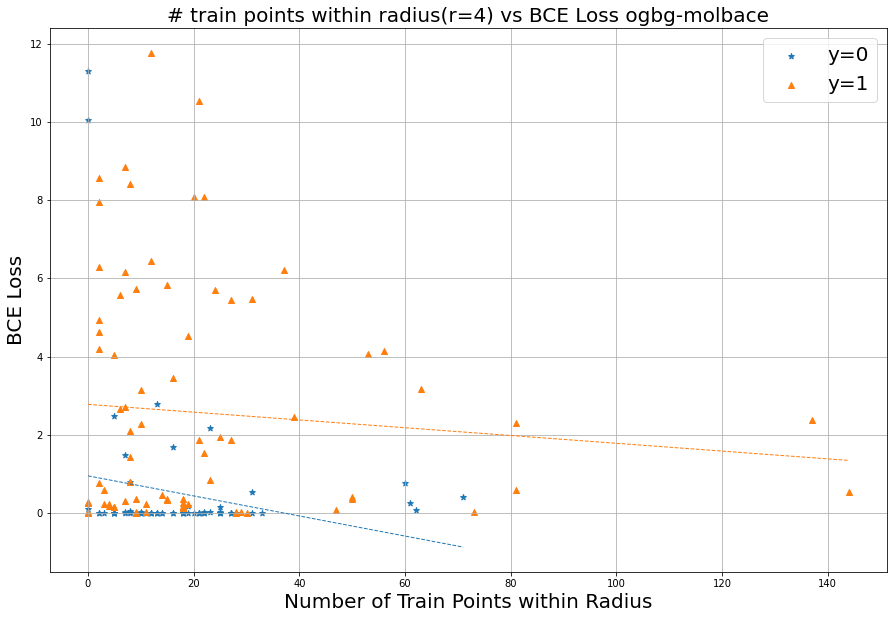

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
shapes = {0: '*', 1: '^'}

# give different shape to points with different y
# 0 -> star, 1 -> triangle
for y, shape in shapes.items():
    mask = test_scaff_losses_df['y'] == y
    x = test_scaff_losses_df.loc[mask, 'train_points_within_radius']
    y_values = test_scaff_losses_df.loc[mask, 'loss']
    plt.scatter(x, y_values, marker=shape, label=f'y={y}')

    # Fit a line to the points
    m, b = np.polyfit(x, y_values, 1)

    # Sort the points by x-value
    x, y_values = zip(*sorted(zip(x, m*x + b)))

    # Plot the line
    plt.plot(x, y_values, linestyle='--', linewidth=1)

ax.set_xlabel('Number of Train Points within Radius', fontsize=20)
if "classification" in labeled_dataset.task_type:
    ax.set_ylabel('BCE Loss', fontsize=20)
    ax.set_title(f'# train points within radius(r={radius}) vs BCE Loss {args.dataset}', fontsize=20)
else:
    ax.set_ylabel('MSE Loss', fontsize=20)
    ax.set_title(f'# train points within radius vs MSE Loss {args.dataset}', fontsize=20)

ax.legend(fontsize=20)
ax.grid(True)
# save the plot
plt.savefig(f'./results/{args.dataset}/train_points_within_radius_vs_loss.png', facecolor='w')

plt.show()